## Setting up environment

In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

In [3]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

## Loading data

In [41]:
data = pd.read_csv("https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/main/output-data/v0.9.0/reports/atlas/validation-v5.csv")
data.head()

,sex,consortium_name,dataset,tool,modality,reported_organ,organ,organId,rui_location_volume,cell_id,cell_label,cell_count,percentage
0,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002063,AT2,758,0.145294
1,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002062,AT1,745,0.142802
2,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,ASCTB-TEMP:non-classical-monocytes,Non-classical monocytes,623,0.119417
3,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002144,EC general capillary,561,0.107533
4,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0000913,CD8 T cells,478,0.091624


## Cleaning up strings and setting categorical variables

In [46]:
#Update organ names for clarity for labels
data.organ = data.organ.str.replace("left ","", regex=True)
data.organ = data.organ.str.replace("right ","", regex=True)
data.organ = data.organ.str.replace("Set of ","", regex=True)
data.organ = data.organ.str.title()
data.organ = data.organ.str.replace("In","in", regex=True)

# Set revised values to categories

data.organ = data.organ.astype("category")
data['organCode'] = data['organ'].cat.codes
data.organId = data.organId.astype("category")
data.reported_organ = data.reported_organ.astype("category")
data.consortium_name = data.consortium_name.astype("category")
data['consCode'] = data['consortium_name'].cat.codes
data.dataset = data.dataset.astype("category")
data.modality = data.modality.astype("category")
data.cell_id = data.cell_id.astype("category")
data.cell_label = data.cell_label.astype("category")

## Create Pivot tables using datasets and cell_ids.

The first pivot table collects the measured cell type counts for each dataset. The second pivot table collects the percentage of cell types for each dataset. Both use the minimum aggregation function, as is only one measurement per cell type per data set.

In [47]:
data_celltype = data.pivot_table(index=['dataset','organ'],
                                 columns='cell_id',
                                 values='cell_count',
                                 aggfunc='min',
                                 fill_value='0',
                                 observed=True,
                                 margins=False)

In [53]:
data_organs = data[['dataset','organ','organCode']].drop_duplicates()
data_consortium = data[['dataset','consortium_name','consCode']].drop_duplicates()



In [21]:
data_cellperc = data.pivot_table(index=['dataset','organ'],
                                 columns='cell_id',
                                 values='percentage',
                                 aggfunc='min',
                                 fill_value='0',
                                 observed=True,
                                 margins=False)

## UMAP Analysis

In [22]:
scaled_data_celltype = StandardScaler().fit_transform(data_celltype)

In [23]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_data_celltype)
embedding.shape

(553, 2)

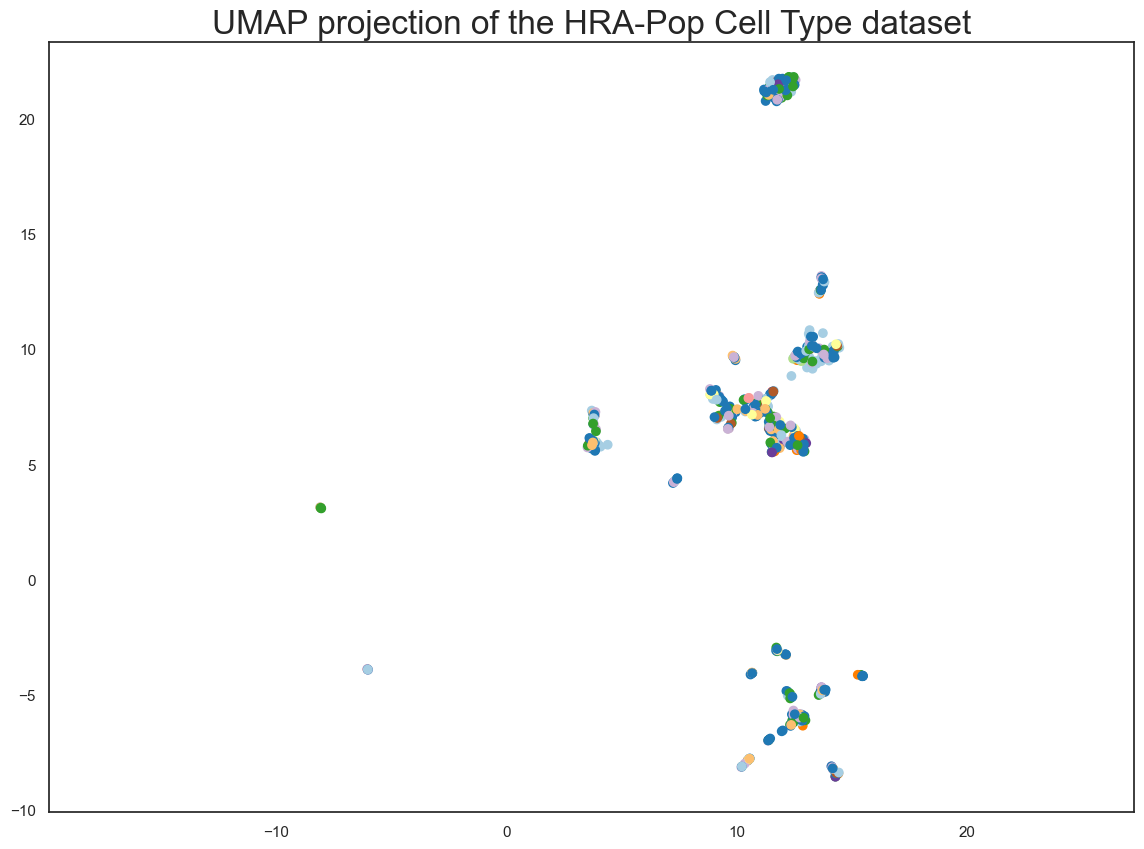

In [58]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=data_organs.organCode,  cmap='Paired'
#    c=data_consortium.consCode, cmap='Spectral'
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the HRA-Pop Cell Type dataset', fontsize=24);